# Progetto Linguistica Computazionale (Modulo B)
## INTRODUZIONE  

Questo progetto nasce come estensione del lavoro svolto nella mia **tesi di laurea** triennale. Nel capitolo 4 di essa, ho descritto la parte sperimentale, in cui ho raccolto manualmente una serie di commenti dal [**Forum dei Brutti**](https://ilforumdeibrutti.is/). Le conversazioni selezionate avevano come tema centrale le **app di dating** (come Tinder, Hinge, Bumble, ecc.), e i commenti sono stati selezionati e salvati in un *file Excel*: "**Analisi chat FDB_Tesi**".

Su questi commenti è stata effettuata un'**annotazione manuale** in cui ho identificato:
- il **sentiment** espresso (positivo, negativo, neutro),
- le **tematiche principali** (affidabilità, inganno, costo, utilità),
- le **emozioni** sottostanti (speranza, scetticismo, frustrazione).

Successivamente, nel mese di *maggio 2025*, è stato sviluppato un **codebook** questo definisce con precisione i criteri di annotazione relativi a *sentiment, tematiche ed emozioni*, e ci ha permesso di mantenere una coerenza metodologica durante l’annotazione manuale.

Questo strumento, che useremo anche come base per le classificazioni di questo progetto, è stato elaborato insieme alla Dottoranda *Selenia Anastasi* per un  **paper** collegato alla mia tesi.
Il lavoro, dal titolo **"Tinder is overrated": Neoliberal Affective Economies in an Italian Incel Forum**, è stato accettato per la conferenza internazionale [**CMC 2025**](https://www.cmc2025.uni-bayreuth.de/en/index.html). 

---
### Obiettivo di questo progetto

L’obiettivo di questo notebook è replicare, in forma automatizzata, parte dell’analisi svolta manualmente, strutturando il lavoro in **tre fasi principali**:

1. **Analisi del sentiment** tramite Word2Vec e Word2Vec locale,
2. **Individuazione delle tematiche** con Sentence Transformer (modello: distiluse-base-multilingual-cased-v1),
3. **Riconoscimento delle emozioni** con Sentence Transformer (modello: paraphrase-albert-small-v2).

Al termine **confronteremo i risultati ottenuti automaticamente con quelli dell’annotazione manuale**, per valutare il grado di corrispondenza tra gli approcci e capire quali aspetti si prestano maggiormente a essere rilevati tramite strumenti di NLP, e quali invece risultano più complessi da automatizzare.

## 1. ANALISI DEL SENTIMENT

In [ ]:
!pip install kagglehub[pandas-datasets]
!python -m spacy download it_core_news_sm
!pip install -q sentence-transformers
!pip install -q scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 86.9 MB/s eta 0:00:00:00:010:01
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━

### Le librerie utilizzate:
- `Pandas`: per la  gestione DataFrame;
- `SpaCy`: per la Tokenizzazione, POS tagging, stopword removal, lemmatizzazione;
- `It_core_news_sm`: perché il nostro dataset è in lingua italiana;
- `Emoji`: Rimozione dei simboli grafici (faccine, simboli Unicode, ecc.);
- `Gensim`: (api) per scaricare e utilizzare modelli preaddestrati Word2Vec (es.glove-wiki-gigaword-50);
- `Word2Vec`(da gensim.models): per l’addestramento di un modello personalizzato Word2Vec sui commenti del dataset;
- `NumPy`: è una libreria per lavorare con array di numeri e fare calcoli matematici veloci;
- `Argmax`: per trovare l’indice del valore massimo in un array o in una lista;
- `Matplotlib` e `Seaborn`: per la creazione dei grafici;
- `Os`: consente di interagire con il sistema operativo.

In [ ]:
import pandas as pd
import spacy
import it_core_news_sm
import emoji
import gensim.downloader as api
from gensim.models import Word2Vec
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors 

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" #dopo l’installazione delle librerie, 
#ho disabilitato il parallelismo dei tokenizer, come suggerito nel messaggio di WARNING stesso. 

In [ ]:
nlp = spacy.load("it_core_news_sm") #Equivalente: nlp = it_core_news_sm.load()

#Per leggere i dati utilizziamo la funzione della libreria pandas: pd.read_csv()
percorso_file = "/kaggle/input/dataset-fdb/Dataset_FDB.csv"
df = pd.read_csv(percorso_file)
print("Le prime righe del dataset:")
df.head()

Le prime righe del dataset:


,Commenti
0,"riapro questo topic qui, il tema è stato più v..."
1,Andrò controcorrente evitando di dire che se n...
2,Su tinder devi avere il gold o il platino ma d...
3,"Si tutti scam, ci sono stati anche dei servizi..."
4,"Peggio che nella vita reale, in queste app i r..."


### Liste di parole-chiave (positive, negative)
Nella prossima cella definiamo **due liste di parole**, queste contengono delle parole (estratte e associate manualmente) che utilizzeremo come riferimento per ciascuna categoria di sentiment. Successivamente, queste liste verranno utilizzate nella fase di calcolo della similarità per confrontare i token dei commenti con ciascuna categoria.

Le liste contengono anche *termini, abbreviazioni e sigle* tipiche del *linguaggio* usato dagli utenti nel forum analizzato.  
Questi elementi sono stati inseriti nelle rispettive liste tenendo conto del **significato** che assumono all'interno di quel contesto specifico e **in base al modo** in cui vengono utilizzati dagli utenti stessi.


In [ ]:
#es.Chad - Stacy - Prime - Match.
parole_positive = ["piace", "bene", "chad", "sicuramente","funzionano","bello", "gold","funziona", "successo", "speranza", 
                   "carina","vantaggio", "stacy", "prime", "buona", "bellezza", "ottieni", "ideale", "benissimo", "vincere",
                   "supermatch", "match", "matchasti","super","soddisfazioni", "provarci", "preferenza", "pace", "nuovo",
                   "merito", "meraviglia","interesse", "interessanti", "innamorata","giusto", "free", "fortuna","efficace",
                   "bravo", "bravissimo", "attraente", "appetibile","appagante", "adatta", "accettano"]

#es.Np - Belloccio - Sub - Normaloide - Megere - Ipergamia - Wallata - Vaginomunite - Oldcel.
parole_negative = ["np", "cazzo", "scam", "scopare", "fake","arpie", "spastiche","belloccio", "sub", "normaloide", 
                   "megere", "ghostato","coglioni", "racchie","puttane", "normie", "minchia", "ipergamia", "ghosting", 
                   "feccia","zoccole", "wallata","obese","vaginemunite", "troie", "torturarsi","swappano", "subumani", 
                   "socialona", "sfruttati","sfanculata","scassacazzo", "satana", "rincoglionite","pecoroni", "oldcel", 
                   "normies", "muscolati","moggarle", "minkiate", "ipergamare", "incellone", "false", "egoboostare", "celebrolese"]

print(f"Parole positive:{len(parole_positive)}")
print("___ \n")
print(f"Parole negative:{len(parole_negative)}") 

Parole positive:45
___ 

Parole negative:45


### Pulizia del dataset
#### 1.1 Minuscolo
Analizzando il dataset che abbiamo deciso di prendere come riferimento, prima di procedere con l'utilizzo del **modello Word2Vec** è necessario svolgere alcune operazioni di **preprocessing linguistico**.
Il primo passo è la *normalizzazione del testo*, iniziamo la conversione di tutti i commenti in minuscolo, così da uniformare parole che, pur essendo identiche nel significato, differiscono solo per l’uso delle maiuscole.

In [ ]:
df["Minuscolo"] = df["Commenti"].str.lower()
display(df[["Commenti", "Minuscolo"]]) #.head(7)) #--> visualizziamo le prime 7,si parte da 0.

df.to_csv("Dataset_FDB_aggiornato.csv", index=False, encoding="utf-8")
print("___ \n")
print("File salvato: Dataset_FDB_aggiornato.csv")

,Commenti,Minuscolo
0,"riapro questo topic qui, il tema è stato più v...","riapro questo topic qui, il tema è stato più v..."
1,Andrò controcorrente evitando di dire che se n...,andrò controcorrente evitando di dire che se n...
2,Su tinder devi avere il gold o il platino ma d...,su tinder devi avere il gold o il platino ma d...
3,"Si tutti scam, ci sono stati anche dei servizi...","si tutti scam, ci sono stati anche dei servizi..."
4,"Peggio che nella vita reale, in queste app i r...","peggio che nella vita reale, in queste app i r..."
...,...,...
207,Io mi ritrovai con una che non mi piaceva e le...,io mi ritrovai con una che non mi piaceva e le...
208,Capitato ormai anni fa…lei carina mentre io in...,capitato ormai anni fa…lei carina mentre io in...
209,Io conosciuto una su Badoo anni e anni fa e mi...,io conosciuto una su badoo anni e anni fa e mi...
210,Il tempo di vedermi e si infilò nella smart pe...,il tempo di vedermi e si infilò nella smart pe...


___ 

File salvato: Dataset_FDB_aggiornato.csv


#### 1.2 Emoji
I commenti che stiamo analizzando provengono da un **forum**, ovvero un contesto informale in cui è **frequente l’utilizzo di emoji e simboli grafici**.
Questi elementi non rientrano tra le informazioni linguistiche che intendiamo analizzare, per questo procediamo con la loro rimozione.

Nel processo di pulizia del testo si poteva utilizzare anche la libreria delle **espressioni regolari (re)* *(stringhe speciali che definiscono un modello (pattern) da cercare in testi. Vengono usate per filtrare, validare, trovare o sostituire porzioni di testo)*, in questo caso avremmo scritto:

**import re**   
...  
**df["no_emoji"] = [re.sub(r'[^\w\s]', '', t) for t in df["Minuscolo"]]**  

*#Per lavorare con Dataset su/con pandas*  
**df["no_emoji"] = df["no_emoji"].str.replace(r'[^\w\s]', '', regex=True)**   
...  

Questo avrebbe rimosso tutti i **caratteri** che **NON sono lettere, numeri o spazi**, quindi anche la punteggiatura, ma quest'ultima volevo eliminarla utilizzando spacy. In generale, ho preferito utilizzare la liberia emoji perchè è progettata appositamente per riconoscerli e rimuoverli in modo preciso. 

In [ ]:
df = pd.read_csv("Dataset_FDB_aggiornato.csv")
df["No_emoji"] = [emoji.replace_emoji(t, replace="") for t in df["Minuscolo"]]

display(df[["Commenti", "Minuscolo", "No_emoji"]]) 
print("___ \n")
df.to_csv("Dataset_FDB_aggiornato.csv", index=False, encoding="utf-8")
print("File salvato: Dataset_FDB_aggiornato.csv")

,Commenti,Minuscolo,No_emoji
0,"riapro questo topic qui, il tema è stato più v...","riapro questo topic qui, il tema è stato più v...","riapro questo topic qui, il tema è stato più v..."
1,Andrò controcorrente evitando di dire che se n...,andrò controcorrente evitando di dire che se n...,andrò controcorrente evitando di dire che se n...
2,Su tinder devi avere il gold o il platino ma d...,su tinder devi avere il gold o il platino ma d...,su tinder devi avere il gold o il platino ma d...
3,"Si tutti scam, ci sono stati anche dei servizi...","si tutti scam, ci sono stati anche dei servizi...","si tutti scam, ci sono stati anche dei servizi..."
4,"Peggio che nella vita reale, in queste app i r...","peggio che nella vita reale, in queste app i r...","peggio che nella vita reale, in queste app i r..."
...,...,...,...
207,Io mi ritrovai con una che non mi piaceva e le...,io mi ritrovai con una che non mi piaceva e le...,io mi ritrovai con una che non mi piaceva e le...
208,Capitato ormai anni fa…lei carina mentre io in...,capitato ormai anni fa…lei carina mentre io in...,capitato ormai anni fa…lei carina mentre io in...
209,Io conosciuto una su Badoo anni e anni fa e mi...,io conosciuto una su badoo anni e anni fa e mi...,io conosciuto una su badoo anni e anni fa e mi...
210,Il tempo di vedermi e si infilò nella smart pe...,il tempo di vedermi e si infilò nella smart pe...,il tempo di vedermi e si infilò nella smart pe...


___ 

File salvato: Dataset_FDB_aggiornato.csv


#### 1.3 Spacy
Continuiamo a lavorare sul nostro dataset, ma adesso utilizziamo la **libreria spaCy**, questa ci consente di effettuare le seguenti *operazioni linguistiche*:
1. la **tokenizzazione** del testo,
2. la **rimozione della punteggiatura**,
3. la **rimozione delle stop word**,
4. la **rimozione delle preposizioni**,
5. la **rimozione dei numeri**.


Abbiamo già caricato in precedenza il modello linguistico italiano di spaCy: **nlp = spacy.load("it_core_news_sm")** ricordando che la scelta di questo modello è dovuta al fatto che i commenti provengono da un **forum in lingua italiana**, e vogliamo che le operazioni linguistiche (come il *riconoscimento delle parole, i loro lemmi e le categorie grammaticali*) siano coerenti con il contesto della lingua d’origine.

In [ ]:
#Costruiamo una lista di oggetti spaCy Doc,struttura base su cui lavora spacy e su cui possiamo applicare: token.lemma_, token.is_stop...
df["Doc_spacy"] = [nlp(testo) for testo in df["No_emoji"]] #testo=ogni singola riga nella colonna no_emoji

#Tokenizzazione
df["Token"] = [[token for token in doc] for doc in df["Doc_spacy"]] #estraggo lista di token

#Eliminiamo la punteggiatura
df["No_punteggiatura"] = [[token for token in doc if not token.is_punct] for doc in df["Token"]]

#Rimuoviamo le stopword
df["No_stopword"] = [[token for token in tokens if not token.is_stop] for tokens in df["No_punteggiatura"]]

#Rimuoviamo le preposizioni
df["No_prep"] = [[token for token in tokens if token.pos_ != "ADP"] for tokens in df["No_stopword"]]

#Rimuoviamo i numeri 
df["No_num"] = [[token for token in tokens if token.pos_ != "NUM"] for tokens in df["No_prep"]]

#Estraiamo i lemmi
df["Lemmi"] = [[token.lemma_ for token in tokens] for tokens in df["No_num"]] #tokens=lista di token

display(df[["Doc_spacy","No_punteggiatura","No_stopword","No_prep","No_num","Lemmi"]])
print("___ \n")
df.to_csv("Dataset_FDB_aggiornato.csv", index=False, encoding="utf-8")
print("File salvato: Dataset_FDB_aggiornato.csv")

,Doc_spacy,No_punteggiatura,No_stopword,No_prep,No_num,Lemmi
0,"(riapro, questo, topic, qui, ,, il, tema, è, s...","[riapro, questo, topic, qui, il, tema, è, stat...","[riapro, topic, tema, affrontato, forum, prece...","[riapro, topic, tema, affrontato, forum, prece...","[riapro, topic, tema, affrontato, forum, prece...","[riapro, topic, tema, affrontare, forum, prece..."
1,"(andrò, controcorrente, evitando, di, dire, ch...","[andrò, controcorrente, evitando, di, dire, ch...","[andrò, controcorrente, evitando, minimo, 6,5,...","[andrò, controcorrente, evitando, minimo, 6,5,...","[andrò, controcorrente, evitando, minimo, chan...","[andrò, controcorrente, evitare, minimo, chanc..."
2,"(su, tinder, devi, avere, il, gold, o, il, pla...","[su, tinder, devi, avere, il, gold, o, il, pla...","[tinder, devi, gold, o, platino, devi, assolut...","[tinder, devi, gold, o, platino, devi, assolut...","[tinder, devi, gold, o, platino, devi, assolut...","[tinder, dovere, gold, o, platino, dovere, ass..."
3,"(si, tutti, scam, ,, ci, sono, stati, anche, d...","[si, tutti, scam, ci, sono, stati, anche, dei,...","[scam, servizi, mediatici, ufficiali, dimostra...","[scam, servizi, mediatici, ufficiali, dimostra...","[scam, servizi, mediatici, ufficiali, dimostra...","[scam, servizio, mediatico, ufficiale, dimostr..."
4,"(peggio, che, nella, vita, reale, ,, in, quest...","[peggio, che, nella, vita, reale, in, queste, ...","[reale, app, i, rapporti, sbilanciati, vaginom...","[reale, app, i, rapporti, sbilanciati, vaginom...","[reale, app, i, rapporti, sbilanciati, vaginom...","[reale, app, il, rapporto, sbilanciare, vagino..."
...,...,...,...,...,...,...
207,"(io, mi, ritrovai, con, una, che, non, mi, pia...","[io, mi, ritrovai, con, una, che, non, mi, pia...","[ritrovai, piaceva, piaceva, punto, chiamare, ...","[ritrovai, piaceva, piaceva, punto, chiamare, ...","[ritrovai, piaceva, piaceva, punto, chiamare, ...","[ritrovaire, piacere, piacere, punto, chiamare..."
208,"(capitato, ormai, anni, fa, …, lei, carina, me...","[capitato, ormai, anni, fa, lei, carina, mentr...","[capitato, ormai, carina, inguardabile, inutil...","[capitato, ormai, carina, inguardabile, inutil...","[capitato, ormai, carina, inguardabile, inutil...","[capitare, ormai, carinare, inguardabile, inut..."
209,"(io, conosciuto, una, su, badoo, anni, e, anni...","[io, conosciuto, una, su, badoo, anni, e, anni...","[conosciuto, badoo, bastato, andato, veloce, s...","[conosciuto, badoo, bastato, andato, veloce, s...","[conosciuto, badoo, bastato, andato, veloce, s...","[conoscere, badoo, bastare, andare, veloce, sc..."
210,"(il, tempo, di, vedermi, e, si, infilò, nella,...","[il, tempo, di, vedermi, e, si, infilò, nella,...","[vedermi, infilò, smart, fuggire]","[vedermi, infilò, smart, fuggire]","[vedermi, infilò, smart, fuggire]","[vedere mi, infilò, smart, fuggire]"


___ 

File salvato: Dataset_FDB_aggiornato.csv


#### Lemmatizziamo (?)
Adesso proviamo a lemmatizzare anche le liste di parole di riferimento (positive, negative). 
___ 
Sapendo che il confronto tra lemmi e altri lemmi sarebbe la scelta più corretta dal punto di vista linguistico, nel nostro caso specifico, la lemmatizzazione automatica introduce alcune distorsioni: ad esempio, alcune parole o sigle vengono lemmatizzate in modo errato:  
es.**Hinge --> Ingevere**.

Questo tipo di errore potrebbe essersi verificato anche durante la **lemmatizzazione dei commenti** nel nostro dataset. Per questo motivo, da questo punto in poi, considereremo esclusivamente i **TOKEN** (ovvero le forme originali delle parole), senza applicare la lemmatizzazione. Questa scelta ci permette di evitare problemi legati a una lemmatizzazione imprecisa e di mantenere maggiore fedeltà al testo originale, soprattutto per nomi propri, sigle o termini gergali.

In [ ]:
def lemmi_lista(lista_parole): #funzione: lemmi_lista
    lemmi = []
    for parola in lista_parole:
        doc = nlp(parola) #passa una parola alla volta applicando spacy
        for token in doc: #Ciclo su tutti i token trovati da spaCy: es.nlp("buonissimo") produce 1 token, ma nlp("non male") ne produce 2, in questo modo ci concentriamo solo su 1 token per volta.
            lemmi.append(token.lemma_)
    return lemmi

parole_pos_lemmi = lemmi_lista(parole_positive)
parole_neg_lemmi = lemmi_lista(parole_negative)

print("Lemmi positivi:", parole_pos_lemmi)
print("___ \n")
print("Lemmi negativi:", parole_neg_lemmi)
     
#print(f"parole_pos_lemmi:{len(parole_pos_lemmi)}") #volevo verificare se ci fossero più/meno parole rispetto le liste iniziali  
#print(f"parole_neg_lemmi:{len(parole_neg_lemmi)}") 

Lemmi positivi: ['piacere', 'bene', 'chad', 'sicuramente', 'funzionare', 'bello', 'Gold', 'funzionare', 'successo', 'speranza', 'carinare', 'vantaggio', 'stacy', 'primo', 'buono', 'bellezza', 'ottieno', 'ideale', 'bene', 'vincere', 'supermatch', 'match', 'matchasto', 'super', 'soddisfazione', 'provare ci', 'preferenza', 'pacere', 'nuovo', 'merito', 'meraviglia', 'interesse', 'interessante', 'innamorato', 'giusto', 'free', 'fortuna', 'efficace', 'bravo', 'bravo', 'attraente', 'appetibile', 'appagare', 'adattare', 'accettare']
___ 

Lemmi negativi: ['np', 'cazzo', 'scam', 'scopare', 'fake', 'arpia', 'spastico', 'belloccio', 'sub', 'normaloido', 'megere', 'ghostare', 'coglione', 'racchia', 'puttano', 'normia', 'minchiare', 'ipergamia', 'ghosting', 'Feccia', 'zoccole', 'wallata', 'obese', 'vaginemunita', 'troia', 'torturare si', 'swappano', 'subumano', 'socialonare', 'sfruttare', 'sfanculare', 'scassacazzo', 'satano', 'rincoglionito', 'pecorone', 'oldcel', 'normies', 'muscolato', 'moggare 

#### "Colpo di scena" 
Sì, è vero. Tutta questa prima parte poteva essere riassunta in una singola, piccola e significante... funzione e con poche righe di codice!

___  

Per rendere il codice più essenziale, quindi, applicheremo alla colonna **"No_emoji"** direttamente un **filtro finale** conservando in questo modo solo i token che appartengono alle seguenti categorie grammaticali e che sono le classi più rilevanti per la nostra analisi: 
- **Aggettivi (ADJ),**
- **Sostantivi (NOUN),**
- **Verbi (VERB)**
- **Avverbi (ADV)**. 

In [ ]:
df = pd.read_csv("Dataset_FDB_aggiornato.csv")

def processa_testo(testo):
    doc = nlp(testo) #analizziamo con spacy
    pos_valide = ["ADJ", "NOUN", "VERB", "ADV"] #filtriamo i token,teniamo solo quelli utili
    tokens = [token.text for token in doc if not token.is_punct and not token.is_stop and token.pos_ in pos_valide]
    return tokens #lista di parole utili per la nostra analisi
    
df["Token"] = df["No_emoji"].apply(processa_testo)
#.apply(funzione) --> applica la funzione(def) a ogni singola cella di quella colonna.

display(df[["No_emoji", "Token"]].head(10)) #stampo i primi 10 partendo da 0
print("___ \n")
df.to_csv("Dataset_FDB_aggiornato_breve.csv", index=False, encoding="utf-8")
print("File salvato: Dataset_FDB_aggiornato_breve.csv")

,No_emoji,Token
0,"riapro questo topic qui, il tema è stato più v...","[riapro, topic, tema, affrontato, forum, prece..."
1,andrò controcorrente evitando di dire che se n...,"[andrò, controcorrente, evitando, minimo, chan..."
2,su tinder devi avere il gold o il platino ma d...,"[tinder, platino, assolutamente, boost, cioè, ..."
3,"si tutti scam, ci sono stati anche dei servizi...","[scam, servizi, mediatici, ufficiali, dimostra..."
4,"peggio che nella vita reale, in queste app i r...","[reale, app, rapporti, sbilanciati, vaginomuni..."
5,hai spiegato perfettamente perchè queste app n...,"[spiegato, perfettamente, app, funzionano, fun..."
6,per me tutte le dating app andrebbero bannate ...,"[dating, app, bannate, cause, sconfinata, inar..."
7,crude le dating apps,"[crude, dating, apps]"
8,"si , pure io ho avuto questa impressione\n tin...","[impressione, tinder, porta, risultato, paghi,..."
9,giusto ieri abbiamo spottato con dei miei amic...,"[giusto, spottato, amici, pazza, perditempo, t..."


___ 

File salvato: Dataset_FDB_aggiornato_breve.csv


#### Word2Vec ...e WordNet?
Per questo progetto ho scelto di utilizzare un **modello Word2Vec** pre-addestrato **"word2vec-google-news-300"** invece di utilizzare strumenti più classici come WordNet. La decisione nasce dalla necessità di lavorare su un **linguaggio informale, con delle sigle, neologismi e termini gergali, come quello presente nei commenti del forum analizzato**. 

Word2Vec, infatti, non si limita a classificare parole in base al loro significato “da dizionario”, ma costruisce vettori semantici basati su come le parole compaiono in testi reali.
___

**Riferimenti:**
- [Documentazione Wordnet](https://wordnet.princeton.edu/documentation)
- [Documentazione modello word2vec-google-news-300](https://huggingface.co/fse/word2vec-google-news-300)
- [Google Archive Word2vec](https://code.google.com/archive/p/word2vec/)

In [ ]:
#Verifichiamo i modelli disponibili
print("Modelli disponibili:")
print(list(api.info()['models'].keys()))

Modelli disponibili:
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
#Carichiamo il modello:
modello_w2v = api.load("word2vec-google-news-300")
print("Modello caricato")

Modello caricato


#### Calcolo della Similarità
Dopo aver caricato il dataset aggiornato (`df`), nella successiva cella definiamo la funzione `trova_sim_max`.    
Questa funzione ha il compito di calcolare, per ogni commento del dataset, la **similarità massima** tra ciascun token del commento stesso e tutte le parole presenti in due liste di riferimento: una lista di **parole positive** (`lista_pos`) e una di **parole negative** (`lista_neg`).  
Il calcolo viene effettuato utilizzando i **word embeddings** forniti dal modello (`modello_w2v`).

Nella funzione, per ogni token vengono confrontate le similarità con tutte le parole positive e negative:
- I valori di similarità vengono salvati nella lista `similarita`, mentre le relative etichette ("Positivo" o "Negativo") vengono inserite in `classi`.
- Alla fine del ciclo, si identifica la posizione del valore massimo in `similarita` tramite la funzione `argmax` di numpy, e si recupera sia il valore massimo (`sim_max`), sia la classe corrispondente (`classe_best`).
- Se nessuna similarità viene trovata (ad esempio, se i token o le parole di riferimento non sono nel modello), viene assegnata la classe "Neutro".

In [ ]:
df = pd.read_csv("Dataset_FDB_aggiornato_breve.csv")
def trova_sim_max(tokens, lista_pos, lista_neg, modello_w2v): #input: lista di parole+lista di parole di riferimento
    similarita = []
    classi = []
    
    for token in tokens: #per ogni token nel commento calcoliamo la distanza vettoriale
        if token in modello_w2v: #evitiamo di calcolare la similarità per parole che il modello non conosce=errore
            for p in lista_pos: #confrontiamo ogni parola p nella lista delle p.positive
                if p in modello_w2v: #controlla se la parola positiva p è presente nel modello Word2Vec
                    similarita.append(modello_w2v.similarity(token, p)) #cosine similarity tra vettore della parola e vettore della parola p usando il modello word2vec e aggiunge il risultato alla lista similarita
                    classi.append("Positivo")
            for n in lista_neg: #similarità con parole in lista negativa presente nel modello
                if n in modello_w2v:
                    similarita.append(modello_w2v.similarity(token, n)) #risultato tra 1 e 0/(-1) che indicherà quanto semanticamente sono vicine queste due parole secondo w2v
                    classi.append("Negativo")

    if similarita #se la lista non è vuota
        idx_max = np.argmax(similarita #argmax per recuperare il valore massimo di sim
        sim_max = similarita[idx_max]
        classe_best = classi[idx_max] #recupera l'etichetta associata a quel max
    else:  #se la lista è vuota
        sim_max = 0
        classe_best = "Neutro" #associamo questa etichetta perché non sono state trovate similarità
    return sim_max, classe_best

Nella prossima cella la **funzione** `trova_sim_max` viene **applicata a tutti i commenti** del dataset.  
Quindi, per ogni commento, verrà calcolato il massimo valore di similarità rispetto alle liste di parole positive e negative, e verrà assegnata l’**etichetta di sentiment** più appropriata ("Positivo", "Negativo" o "Neutro").  
Infine, i risultati verranno aggiunti come **nuove colonne nel DataFrame** e salvati in un file aggiornato.

In [ ]:
lista_sim_max= []  #per salvare la similarità massima di ogni commento
lista_sentimento = [] #salvare l’etichetta del sentiment 

for tokens in df["Token"]: #applichiamo la funzione e salviamo i 2 risultati restituiti dalla funz.
    sim, sentimento = trova_sim_max(tokens, parole_positive, parole_negative, modello_w2v)
    lista_sim_max.append(sim)
    lista_sentimento.append(sentimento)
#salviamo il valore massimo di sim. e l'etichetta associata
df["sim_max"] = lista_sim_max
df["Sentiment"] = lista_sentimento

print(df[["sim_max", "Sentiment"]].head(10))
df.to_csv("Dataset_FDB_aggiornato_breve.csv", index=False, encoding="utf-8")
print("File aggiornato: Dataset_FDB_aggiornato_breve.csv")

    sim_max Sentiment
0  0.523261  Negativo
1  0.648607  Positivo
2  0.648607  Positivo
3  0.523261  Negativo
4  0.515331  Negativo
5  0.571140  Positivo
6  0.515331  Negativo
7  0.515331  Negativo
8  0.523261  Negativo
9  0.571140  Positivo
File aggiornato: Dataset_FDB_aggiornato_breve.csv


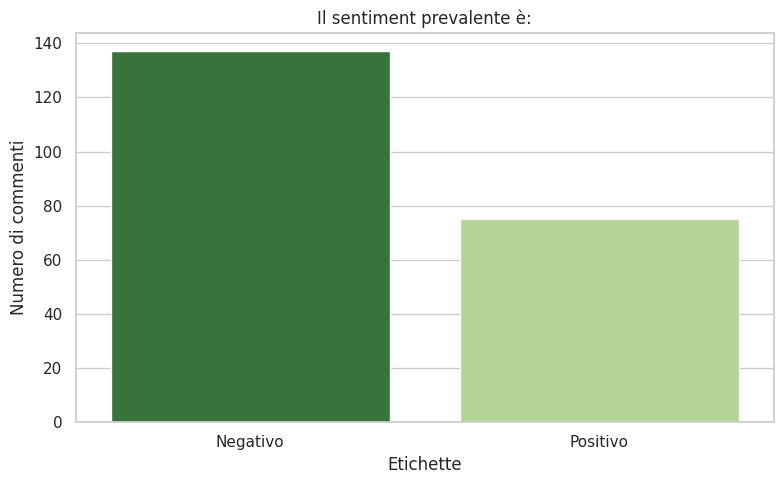

In [ ]:
#GENERIAMO IL GRAFICO:
sfumature_verdi = ["#2e7d32", "#b2df8a", "#66bb6a"]
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Sentiment", palette=sfumature_verdi)

#Titolo ed etichette
plt.title("Il sentiment prevalente è:")
plt.xlabel("Etichette")
plt.ylabel("Numero di commenti")
plt.tight_layout()
plt.show()

### Word2vec locale
Adesso realizziamo un **modello Word2vec locale**, in *italiano*, partendo dai miei dati, e quindi utilizzando i **token** già estratti dal dataset, così da evitare problemi di **compatibilità linguistica** (che si potevano avere quando abbiamo usato word2vec-google-news-300, che è basato sull'inglese).
___
**Riferimento:**
- [Documentazione W2C locale](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.BrownCorpus)


In [ ]:
#se il modello preaddestrato non funziona,c'è questo locale,basato sui miei commenti= fallback.
df = pd.read_csv("Dataset_FDB_aggiornato.csv")
def estrai_token(testo):
    doc = nlp(testo)
    pos_valide = ["ADJ", "NOUN", "VERB", "ADV"]
    return [token.text for token in doc if not token.is_punct and not token.is_stop and token.pos_ in pos_valide]

df["Token"] = df["No_emoji"].apply(estrai_token)

display(df[["No_emoji", "Token"]].head(5))
print(type(df["Token"].iloc[0]))  #Verifichiamo, deve essere <class 'list'>
df.to_csv("Dataset_FDB_w2v_locale.csv", index=False, encoding="utf-8")
print("File salvato: Dataset_FDB_w2v_locale.csv")

,No_emoji,Token
0,"riapro questo topic qui, il tema è stato più v...","[riapro, topic, tema, affrontato, forum, prece..."
1,andrò controcorrente evitando di dire che se n...,"[andrò, controcorrente, evitando, minimo, chan..."
2,su tinder devi avere il gold o il platino ma d...,"[tinder, platino, assolutamente, boost, cioè, ..."
3,"si tutti scam, ci sono stati anche dei servizi...","[scam, servizi, mediatici, ufficiali, dimostra..."
4,"peggio che nella vita reale, in queste app i r...","[reale, app, rapporti, sbilanciati, vaginomuni..."


<class 'list'>
File salvato: Dataset_FDB_w2v_locale.csv


#### Addestramento del modello
Inizialmente viene preparato il **corpus** di testo estraendo i token da ogni commento e li trasformiamo in una lista di liste di parole.  
Successivamente, viene addestrato un modello **Word2Vec locale** direttamente sui dati del nostro dataset, utilizzando i parametri più adatti a corpus di *dimensioni ridotte.*  
I principali parametri specificati come `vector_size`, `window`, `sg` e `epochs` vengono scelti per garantire che il modello sia in grado di apprendere buone rappresentazioni delle parole anche in presenza di testo limitato o con termini particolari. 
- **sentences=corpus**: il mio corpus;
- **vector_size=200**: ogni parola del vocabolario sarà trasformata in un vettore di 200 numeri,adatto a chi ha poco testo;
- **window=5**: il modello guarda 5 parole prima e 5 dopo la parola target per capire il significato;
- **min_count=1**: parola deve comparire almeno 1 volta;
- **workers=4**: usa 4 processori in parallelo per velocizzare l’addestramento;
- **1 = Skip-gram (0 = CBOW)**: sg=1 = usa Skip-Gram, predice il contesto dato il centro ed è meglio per parole rare (forum o slang). Se sg=0 = usa CBOW, che fa il contrario;
- **epochs=40**: Ripete l’addestramento 40 volte su tutto il corpus per migliorare l’apprendimento.

Al termine dell’addestramento, il modello viene salvato per poter essere riutilizzato nelle fasi successive dell’analisi.

In [ ]:
corpus = df["Token"].tolist()
modello_w2v_locale = Word2Vec(sentences=corpus, vector_size=200, window=5, min_count=1, workers=4, sg=1, epochs=40)
modello_w2v_locale.save("modello_word2vec_locale.model")
print("Modello Word2Vec locale salvato")

Modello Word2Vec locale salvato


Quando addestriamo un modello Word2Vec **locale**, otteniamo un oggetto che contiene sia le informazioni utili per l’addestramento (training), sia i vettori delle parole (word vectors) che ci servono per calcolare similarità, analogie, ecc...
Per accedere in modo diretto e sicuro **ai soli vettori delle parole** e alle funzioni di analisi (ad esempio `most_similar`, `similarity`), si utilizza la proprietà `.wv`:
- `modello_w2v_locale.wv["parola"]` restituisce il vettore della parola.
- `modello_w2v_locale.wv.most_similar("parola")` restituisce le parole più simili.

Quindi:
`.wv` contiene **solo la parte necessaria all’analisi** (i vettori), rendendo il modello più leggero e veloce da usare anche dopo l’addestramento.
L’oggetto "modello" senza `.wv` contiene anche tutto il necessario per continuare o modificare l’addestramento, che non serve più nelle fasi successive di analisi.

Nei modelli pre-addestrati Gensim (come **"word2vec-google-news-300"**) non usiamo **.wv** perché 
quando carichiamo un modello da `gensim.downloader.api` (ad esempio con api.load("word2vec-google-news-300")), il risultato è **già solo l’oggetto dei vettori**, quindi non è necessario (né possibile) aggiungere `.wv`.

___
**Riferimento:**  
[Documentazione Gensim – Word2Vec KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html)

In [ ]:
#esempi:
print(modello_w2v_locale.wv.similarity("chad", "stacy"))
print(modello_w2v_locale.wv.similarity("bella", "feccia"))

0.65568995
0.9820855


#### 1. “chad” e “stacy” → 0.6557
Un valore intorno a **0.65 indica una buona similarità semantica**, ma non identica, quindi il modello ha appreso che “chad” e “stacy” compaiono in contesti simili Così la cosine similarity è positiva e significativa, ma non eccellente né perfetta. Questo rientra nella fascia fra **0.3–0.7 che in NLP indica un’associazione media.**

#### 2. "bella” e “feccia” → 0.9821
Un valore vicinissimo a 1 indica che i due vettori **puntano quasi nella stessa direzione nello spazio semantico**. Questo significa che il modello **ha associato spesso “bella” e “feccia” in contesti simili**, probabilmente perché usati **spesso insieme nei commenti** (es. “bella feccia”, “feccia bella”, sarcasmo, contesti negativi con “bella” usata ironicamente).

In [ ]:
df = pd.read_csv("Dataset_FDB_w2v_locale.csv")
def trova_sim_max(tokens, lista_pos, lista_neg, modello_w2v_locale):
    similarita = []
    classi = []
    
    for token in tokens:
        if token in modello_w2v_locale.wv:
            for p in lista_pos:
                if p in modello_w2v_locale.wv:
                    similarita.append(modello_w2v_locale.wv.similarity(token, p))
                    classi.append("Positivo")
            for n in lista_neg:
                if n in modello_w2v_locale.wv:
                    similarita.append(modello_w2v_locale.wv.similarity(token, n))
                    classi.append("Negativo")

    if similarita:
        idx_max = np.argmax(similarita)
        sim_max = similarita[idx_max]
        classe_best = classi[idx_max]
    else:
        sim_max = 0
        classe_best = "Neutro"
    return sim_max, classe_best

In [ ]:
lista_sim_max= []
lista_sentimento = []

for tokens in df["Token"]:
    sim, sentimento = trova_sim_max(tokens, parole_positive, parole_negative, modello_w2v_locale)
    lista_sim_max.append(sim)
    lista_sentimento.append(sentimento)

df["sim_max"] = lista_sim_max
df["Sentiment"] = lista_sentimento

print(df[["sim_max", "Sentiment"]].head(10))
df.to_csv("DDataset_FDB_w2v_locale.csv", index=False, encoding="utf-8")
print("File aggiornato: Dataset_FDB_w2v_locale.csv")

    sim_max Sentiment
0  0.996651  Negativo
1  0.996651  Negativo
2  0.996651  Negativo
3  0.996651  Negativo
4  0.996651  Negativo
5  0.996651  Negativo
6  0.996651  Negativo
7  0.000000    Neutro
8  0.996651  Negativo
9  0.996651  Negativo
File aggiornato: Dataset_FDB_w2v_locale.csv


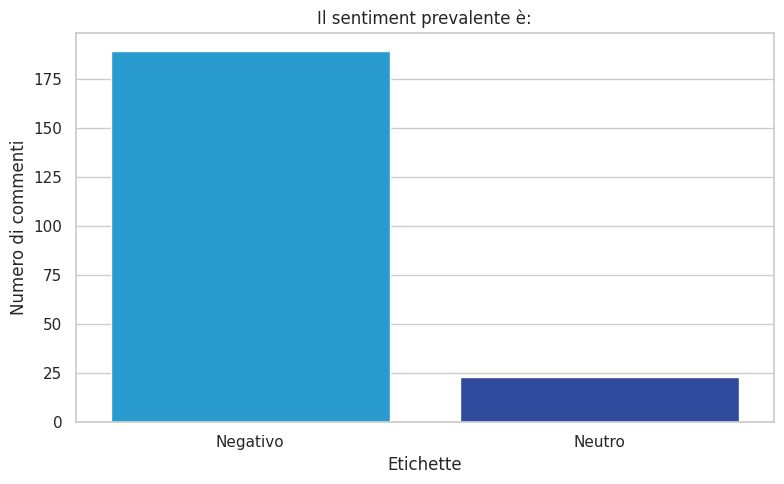

In [ ]:
#GENERIAMO IL GRAFICO
sfumature_blu = ["#0ea5e9", "#1e40af", "#60a5fa"]
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Sentiment", palette=sfumature_blu)

#Titolo ed etichette
plt.title("Il sentiment prevalente è:")
plt.xlabel("Etichette")
plt.ylabel("Numero di commenti")
plt.tight_layout() #regola automaticamente gli spazi nel grafico...per evitare che si sovrappongano 
plt.show()

#### Perché abbiamo ottenuto questo risultato?
1. *Word2Vec impara solo dalle parole realmente presenti e frequenti nei dati.*  
Se nel dataset (nella colonna `"Token"`) le parole positive non appaiono, oppure sono molto rare, il modello **non riuscirà ad apprendere buoni vettori** per esse.
2. Anche impostando `min_count=1` il modello include tutte le parole, *ma se alcune compaiono pochissimo, i loro embedding saranno comunque casuali e poco rappresentativi*.
3. *Se il corpus è piccolo*, i vettori appresi risultano generalmente **molto deboli, quasi “a caso”**: proprio perché il modello locale addestrato su poche centinaia o migliaia di commenti riesce a rappresentare bene solo le parole più frequenti.
4. *Se le parole negative sono molto più comuni nei commenti* (ad esempio in un contesto con molti messaggi arrabbiati o insoddisfatti), il modello “imparerà” meglio quei vettori rispetto alle parole positive.

## 2. ANALISI DELLE TEMATICHE

In questa seconda fase del progetto ci concentriamo sull’identificazione delle **tematiche principali** presenti nei commenti estratti dal forum Incel, sulla base del **codebook sviluppato per il paper CMC2025**.  
L’approccio è *semantico*: invece di analizzare singole parole, consideriamo ogni commento come un'**unità di significato completa**. Usiamo quindi **Sentence Transformers** per calcolare la **similarità semantica** tra i commenti e alcune **frasi standard** definite per ciascuna tematica.

Classificheremo automaticamente ogni commento in una delle **quattro categorie**:
- **Affidabilità**: *Il commento riconosce la potenziale affidabilità o efficacia delle app di dating, ma generalmente a determinate condizioni o per determinate categorie di utenti. L'utente ammette che le app di dating possono funzionare o produrre
risultati positivi in specifiche circostanze.*
- **Inganno**: *Il commento fa riferimento a esperienze o percezioni di inganno, frode o falsità nelle app di dating. L'utente
esprime preoccupazioni relative alla presenza di profili falsi, truffe, bot o account fraudolenti che compromettono l'autenticità dell'esperienza e minano la fiducia nella piattaforma.*
- **Costo**:*Il commento fa riferimento agli aspetti economici delle app di dating, criticando in particolare il modello di business che richiede pagamenti per sbloccare funzionalità essenziali. L'utente esprime frustrazione per la percezione che le app
favoriscano un sistema "pay-to-win" in cui solo chi investe denaro (oltre ad essere attraente) ha possibilità concrete di successo.*
- **Inutilità**: *Il commento esprime la convinzione che le app di dating siano completamente inutili o inefficaci per uomini che non corrispondono agli standard estetici convenzionali (definiti come "sub 7" o non attraenti). L'utente considera che queste
piattaforme rappresentino uno spreco di tempo ed energie per chi non possiede determinate caratteristiche fisiche.*

In [ ]:
from sentence_transformers import SentenceTransformer, util
from sentence_transformers.util import cos_sim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#SE riceveremo un messaggio di "Warning"= questi non sono errori bloccanti, ma warning informativi 
#generati quando usiamo librerie come PyTorch o Sentence Transformers con accelerazione hardware 
#(nel nostro caso:GPU).

In [ ]:
percorso_file = "/kaggle/input/dataset-fdb-com-tem/Dataset_FDB_cet.csv"
df = pd.read_csv(percorso_file)
df = df[["Commenti", "Temi_manuali"]]

print("Prime righe del dataset:")
display(df.head(4))

Prime righe del dataset:


,Commenti,Temi_manuali
0,"riapro questo topic qui, il tema è stato più v...",Inutilità
1,Andrò controcorrente evitando di dire che se n...,Inutilità
2,Su tinder devi avere il gold o il platino ma d...,Costo
3,"Si tutti scam, ci sono stati anche dei servizi...",Inganno


### Frasi standard
Adesso definiamo delle **liste di frasi rappresentative**, una per ciascuna **tematica**: 
- **Affidabilità**, 
- **Inganno**,
- **Costo**,
- **Inutilità**.

Queste frasi sono state **estratte manualmente** all'interno del forum e adesso fungeranno da riferimento semantico per classificare i commenti nel nostro dataset. Mentre, durante le fasi successive, verrà calcolata la **similarità** tra ogni commento e ciascuna di queste frasi standard, e il commento verrà assegnato alla categoria con cui presenta la maggiore somiglianza semantica.

In [ ]:
tematiche = {
    "Affidabilità": ["bravissimo, hinge è attualmente l'app migliore per quanto mi riguarda.",
                     "Non tutte, io qualche appuntamento l'ho rimediato.",
                     "A più utenti del forum ho consigliato hinge, il top secondo me.",
                     "Quando avrò un po’ più di tempo libero, riproverò a rimettermi sulle app (tinder principalmente) con delle foto decenti in bei posti.",
                     "Io mi trovo bene con Meetic."],
    
    "Inganno": ["Si tutti scam.",
                "Da li necessità di bot e profili fake. Risultato una spirale in cui nessuno usa più ste app.",
                "Però che ne so che non erano bot la maggior parte?... l’altra che ho chattato poteva essere pure una IA.",
                "Tanto uno come me cos'altro può aspettarsi se non truffatori nigeriani di merda basati in africa occidentale che mi ucciderebbero per derubarmi di 1000 euro.",
                "Altra infornata di negre truffe su Hinge. Posso mandarvi a cagare quando dite di rimediare 7 vicino a casa?"],
    
     "Costo": ["Su tinder devi avere il gold o il platino ma devi avere assolutamente i BOOST.",
               "Si , pure io ho avuto questa impressione tinder porta a qualche risultato, cioè paghi il platinum.",
               "Paghi per qualsiasi cosa, cioè l'app che installi senza pagare è sostanzialmente una demo.",
               "Tinder è però penalizzante perché l'algoritmo, se non paghi, ti affossa e non ti farà mai comparire.",
               "Su tinder tutt’altra storia feci 1 mese di Platinum in promozione e i risultati furono abbondanti."],
    
    "Inutilità": ["Peggio che nella vita reale, in queste app i rapporti di forza sono troppo sbilanciati a favore delle vaginomunite.",
                  "Minchia beati voi... io sulle app non ho mai rimediato niente.",
                  "Poi vabbè per un cesso vero sub 5 è finita in qualsiasi modo quindi sarebbero solo perdite di tempo.",
                  "Non funzionano le app dating, neanche per i chad, lì si trova solo feccia o appunto gente che vuole solo farsi seguire su IG.",
                  "Post covid, le app per incontri sono decadute."]}

### Scelta del Modello: 
#### distiluse-base-multilingual-cased-v1

Per il calcolo della similarità semantica tra frasi, dalla [**documentazione**](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html):
*"distiluse-base-multilingual-cased-v1 : versione distillata della conoscenza multilingue del codificatore universale di frasi multilingue . Supporta 15 lingue: arabo, cinese, olandese, inglese, francese, tedesco, italiano, coreano, polacco, portoghese, russo, spagnolo, turco."*


Ho scelto di utilizzare questo modello: **distiluse-base-multilingual-cased-v1** fornito da *Sentence Transformers*, soprattutto perché è un modello progettato per supportare molte lingue, tra cui l’**italiano**. Questo lo rende adatto al nostro dataset, che contiene commenti in italiano, scritti in modo informale o con espressioni gergali.

#### Prima di utilizzarlo:
Nel processo di calcolo degli **embedding semantici** con **Sentence Transformers**, ogni commento deve essere fornito come frase testuale. Tuttavia, nei dataset reali (come quello da me utilizzato), possono comparire valori anomali o non testuali, ad esempio:
- celle vuote o NaN (Not a Number),
- numeri,
- simboli,
- errori di encoding.
 
Questi elementi non sono compatibili con il modello SentenceTransformer, che si aspetta in input una lista di frasi, non valori numerici o nulli. Quindi, per evitare errori durante l’encoding, è necessario convertire ogni commento in stringa (str), anche se si tratta di un numero o di un valore anomalo.

In [ ]:
df = df[df["Commenti"].notna()] #mantiene righe non vuote
df["Commenti"] = df["Commenti"].astype(str) #tutte stringhe

print(type(commenti[0])) #mi interessa sapere il tipo dei suoi elementi = se ogni commento è una stringa.
df.to_csv("Dataset_FDB_cet.csv", index=False, encoding="utf-8")
print("File aggiornato: Dataset_FDB_cet.csv")

<class 'str'>
File aggiornato: Dataset_FDB_cet.csv


In [ ]:
modello = SentenceTransformer("distiluse-base-multilingual-cased-v1")
commenti = df["Commenti"].tolist()
embedding_commenti = modello.encode(commenti) #contenuto in embedding=vettore numerico
embedding_commenti

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

array([[-0.05596764, -0.0578989 ,  0.05283777, ..., -0.08689537,
         0.00308896, -0.00396666],
       [ 0.02181151, -0.03704266, -0.0258544 , ..., -0.0808869 ,
        -0.034323  , -0.02462036],
       [-0.06222786, -0.01240618,  0.03282044, ..., -0.01444777,
        -0.01282377,  0.04604583],
       ...,
       [-0.04789818,  0.00892673,  0.03982252, ..., -0.02216597,
        -0.03052361,  0.01250213],
       [-0.0045362 ,  0.03478095,  0.01406121, ...,  0.01931515,
        -0.0913665 ,  0.02453193],
       [-0.0505213 ,  0.04180625,  0.03004912, ..., -0.03763651,
        -0.04125647,  0.04698633]], dtype=float32)

In [ ]:
emb_tematiche = {} #dizionario che, per ogni tematica, contiene la lista dei suoi vettori (embedding)
for tema, frasi in tematiche.items():
    embeddings = [] #raccogliamo gli embedding delle frasi di quella tematica
    for frase in frasi:
        embedding = modello.encode(frase) #calcola embedding della frase=la frase viene trasformata in un vettore numerico con il modello
        embeddings.append(embedding) #salva la lista nel dizionario
    emb_tematiche[tema] = embeddings #sotto il rispettivo nome della tematica
nomi_temi = list(emb_tematiche.keys()) #lista di nomi delle tematiche presenti come chiavi nel dizionario,per scorrere facilmente tutte le tematiche durante il ciclo di classificazione
Temi_predetti = []

for emb_commento in embedding_commenti: #per ogni embedding
    sim_massime = [] #dove salveremo la similarità max
    for tema in nomi_temi:
        sim_frasis = [cos_sim(emb_commento, emb_frase).mean().item() #Calcola la similarità del coseno tra l'embedding del commento 
                      for emb_frase in emb_tematiche[tema]] #e l'embedding della frase di riferimento
        sim_massime.append(max(sim_frasis)) #massimi di tutte le tematiche

    idx_max = np.argmax(sim_massime) #1° tra i massimi di tutte le tematiche, trova l’indice della tematica corrispondente
    Temi_predetti.append(nomi_temi[idx_max])

df["Tema_predetto"] = Temi_predetti
display(df[["Commenti", "Temi_manuali", "Tema_predetto"]].head(10))
df.to_csv("Dataset_FDB_cet.csv", index=False, encoding="utf-8")
print("File aggiornato: Dataset_FDB_cet.csv")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,Commenti,Temi_manuali,Tema_predetto
0,"riapro questo topic qui, il tema è stato più v...",Inutilità,Costo
1,Andrò controcorrente evitando di dire che se n...,Inutilità,Affidabilità
2,Su tinder devi avere il gold o il platino ma d...,Costo,Costo
3,"Si tutti scam, ci sono stati anche dei servizi...",Inganno,Inutilità
4,"Peggio che nella vita reale, in queste app i r...",Inutilità,Inutilità
5,hai spiegato perfettamente perchè queste app n...,Inganno,Inganno
6,per me tutte le dating app andrebbero bannate ...,Inutilità,Inutilità
7,Crude le dating apps,Inutilità,Inutilità
8,"si , pure io ho avuto questa impressione\n tin...",Costo,Costo
9,Giusto ieri abbiamo spottato con dei miei amic...,Inganno,Inutilità


File aggiornato: Dataset_FDB_cet.csv


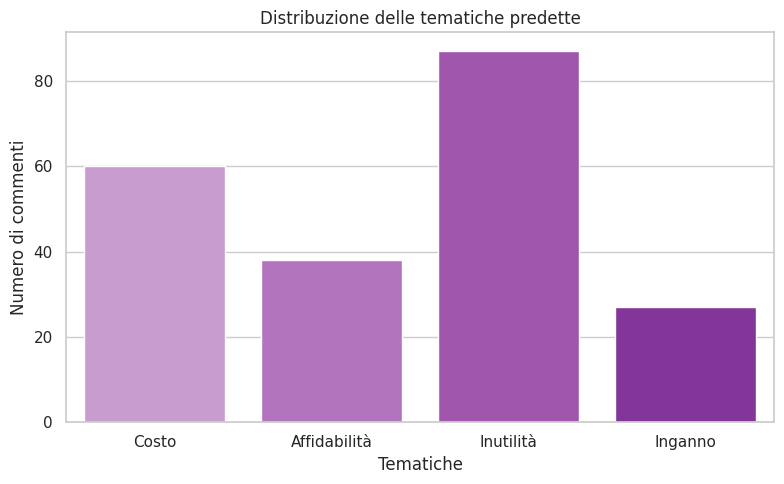

In [ ]:
#GENERIAMO IL GRAFICO
palette_viola = ["#ce93d8", "#ba68c8", "#ab47bc", "#8e24aa"]
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Tema_predetto", palette=palette_viola)

#Titolo ed etichette
plt.title("Distribuzione delle tematiche predette")
plt.xlabel("Tematiche")
plt.ylabel("Numero di commenti")
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv("Dataset_FDB_cet.csv")

if "Temi_manuali" in df.columns and "Tema_predetto" in df.columns:
    print("Report di valutazione tra etichette manuali e predette:")
    print(classification_report(df["Temi_manuali"], df["Tema_predetto"]))

Report di valutazione tra etichette manuali e predette:
              precision    recall  f1-score   support

Affidabilità       0.21      0.57      0.31        14
       Costo       0.25      0.65      0.36        23
     Inganno       0.33      0.26      0.29        35
   Inutilità       0.83      0.51      0.63       140

    accuracy                           0.49       212
   macro avg       0.41      0.50      0.40       212
weighted avg       0.64      0.49      0.53       212



#### Report di valutazione
- **Precision** elevata per **"Inutilità"** perché quando il modello predice questa classe, è corretto nell'83% dei casi.
- **Recall** discreto per **"Costo"** perché riesce a catturare una buona percentuale dei casi reali di questa categoria.
- **Precision** molto bassa per **"Affidabilità"** (0.21) e **"Costo"** (0.25) perchè vi è un alto tasso di falsi positivi.
- **Recall** problematico per **"Inganno"** (0.26): il modello perde il 74% dei casi reali.

Con un'**accuracy complessiva del 49%**, il modello performa appena **sotto la soglia di accettabilità**.   
La weighted average (0.53 F1-score) riflette l'influenza della classe dominante, mentre la macro average (0.40 F1-score) **rivela le reali difficoltà nel gestire tutte le classi equamente.** 

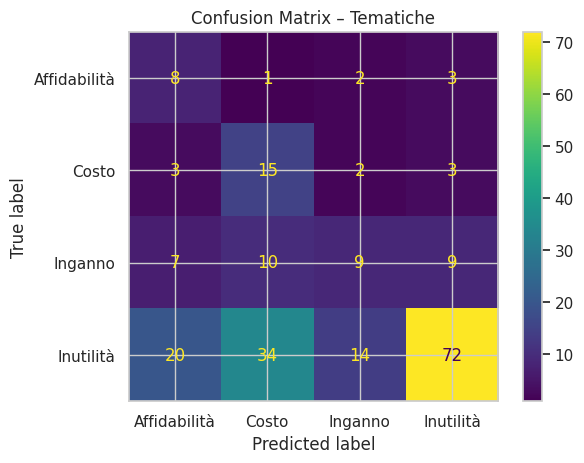

In [ ]:
#Matrice di confusione
df = pd.read_csv("Dataset_FDB_cet.csv")
cm = confusion_matrix(df["Temi_manuali"], df["Tema_predetto"]) #Confrontiamo i valori riga per riga tra standard e predizione
labels = sorted(df["Temi_manuali"].unique()) #Ordiniamo alfabeticamente le etichette manuali per metterle in ordine sulla matrice

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot()
plt.title("Confusion Matrix – Tematiche")
plt.show()

#### Matrice di confusione
La *matrice di confusione* presentata ci permette di visualizzare le **performance** di un modello sviluppato per la **classificazione automatica** di contenuti testuali in lingua italiani,questi sono stati suddivisi in quattro classi tematiche principali: **Affidabilità, Costo, Inganno e Inutilità**.
La rappresentazione grafica utilizza una *mappa di calore (heatmap) con una scala cromatica che varia dal viola scuro (valori bassi, prossimi allo zero) al giallo brillante (valori elevati, fino a 72)*, in queso modo possiamo identificare immediatamente i pattern di classificazione e gli errori del modello.
La matrice è organizzata secondo la convenzione standard:
- **Asse verticale (True label)**: rappresenta le categorie reali, ovvero l'etichettatura corretta dei contenuti;
- **Asse orizzontale (Predicted label)**: mostra le predizioni generate dal modello di classificazione;
- **Valori numerici**: indicano la frequenza assoluta di ogni combinazione predizione-realtà.
  
Il modello mostra una forte capacità predittiva per la classe **"Inutilità"** con 72 predizioni corrette, rappresentando chiaramente la classe dominante nel dataset.Tuttavia, emerge una confusione significativa tra le altre categorie.     
La classe **"Costo"** presenta 15 true positives ma viene spesso *confusa con "Inutilità"* (34 falsi negativi), suggerendo che il modello tende a sovrastimare l'inutilità quando dovrebbe identificare questioni di costo. Anche **"Affidabilità"** e **"Inganno"** mostrano pattern simili di confusione verso "Inutilità".

## 3. ANALISI DELLE EMOZIONI

In questa terza fase del progetto ci concentriamo sull’identificazione delle **emozioni** presenti nei commenti estratti dal forum Incel, sulla base del **codebook sviluppato per il paper CMC2025**.  
L’approccio è *semantico*: invece di analizzare singole parole, consideriamo ogni commento come un'**unità di significato completa**. Usiamo quindi **Sentence Transformers** per calcolare la **similarità semantica** tra i commenti e alcune **frasi standard** definite per ciascuna tematica.

Classificheremo automaticamente ogni commento in una delle **tre categorie**:
- **Speranza**:*Il commento esprime un sentimento di ottimismo o fiducia nella possibilità di ottenere risultati positivi sulle app di dating, nonostante le difficoltà. L'utente manifesta la convinzione che, attraverso determinati cambiamenti, strategie o approcci, sia possibile migliorare la propria esperienza e raggiungere i risultati desiderati in futuro.*
- **Scetticismo**:*Il commento esprime un atteggiamento di dubbio, distacco o valutazione critica ma razionale riguardo alle app di dating. L'utente manifesta una posizione né fortemente negativa né positiva, ma piuttosto una considerazione pragmatica sulle limitazioni o sui problemi strutturali di queste piattaforme, senza un coinvolgimento emotivo intenso.* 
- **Frustrazione**:*Il commento esprime un forte sentimento di insoddisfazione ricorrente, inadeguatezza o impotenza rispetto all'utilizzo delle app di dating. L'utente manifesta rabbia, delusione o sconforto derivanti da esperienze negative ripetute, sensazione di esclusione o impossibilità di raggiungere risultati desiderati nonostante i tentativi.*


In [ ]:
percorso_file = "/kaggle/input/dataset-fdb-emoz/Dataset_FDB_emoz.csv"
df = pd.read_csv(percorso_file)
df = df[["Commenti", "Emozioni_manuali"]]

print("Prime righe del dataset:")
display(df.head(4))

Prime righe del dataset:


,Commenti,Emozioni_manuali
0,"riapro questo topic qui, il tema è stato più v...",Frustrazione
1,Andrò controcorrente evitando di dire che se n...,Frustrazione
2,Su tinder devi avere il gold o il platino ma d...,Scetticismo
3,"Si tutti scam, ci sono stati anche dei servizi...",Frustrazione


### Frasi standard
Adesso definiamo delle **liste di frasi rappresentative**, una per ciascuna **emozione**: 
- **Speranza**, 
- **Scetticismo**,
- **Frustrazione**,

Queste frasi sono state **estratte manualmente** all'interno del forum e adesso fungeranno da riferimento semantico per classificare i commenti nel nostro dataset. Mentre, durante le fasi successive, verrà calcolata la **similarità** tra ogni commento e ciascuna di queste frasi standard, e il commento verrà assegnato alla categoria con cui presenta la maggiore somiglianza semantica.

In [ ]:
Emozioni = {
    "Speranza": ["Si,pure io ho avuto questa impressione tinder porta a qualche risultato, cioè paghi il platinum, è vero, però ottieni anche uscite.",
                 "Ma tinder platino assolutamente approvato, con delle foto decenti e non professionali veramente fai il salto di qualità.",
                 "E si, con le app ci scopo, so di cosa parlo.",
                 "Ovvio,abbassando l eta hai molte più np con cui puoi matchare.",
                 "Non tutte, io qualche appuntamento l'ho rimediato."],
    
    "Scetticismo": ["Personalmente ne ho provate alcune molti anni fa, se non ricordo male Tinder, badoo e meetic. Tutte secondo me hanno una cosa in comune ovvero la perdita di tempo, come è risaputo sei limitato se non paghi.",
                    "secondo me se una sta sulle app dating/social al 99.9% non fa per noi... il BC è alto ecc.",
                    "“sto dicendo che il 99.9% sono tipe in qualche modo da evitare, poi magari 1 su 1000 li si trova.",
                    "Una volta forse era un po' meglio, ma adesso è tutto impostato sul look.",
                    "Dipende sempre da quello che uno vuole, i pro ed i contro, l'eventuale perdita esistenziale."],
    
     "Frustrazione": ["Andrò controcorrente evitando di dire che se non sei minimo un 6,5-7 non hai chances.",
                      "Per me tutte le dating app andrebbero bannate in quanto una delle cause della sconfinata ed inarrestabile ipergamia femminile",
                      "Crude le dating apps.",
                      "Le app sono una truffa e le donne sono una trappola. Simple as that.",
                      "Ci sono ancora dementi che si iscrivono a Tinder.",]}

### Scelta del modello
Modello: **paraphrase-albert-small-v2** visto durante la [lezione 16](https://drive.google.com/file/d/1B10io-LYV6zg-A4Kxfo9_RJr1uN7dgxe/view?usp=sharing)

#### Prima di utilizzarlo:
Nel processo di calcolo degli **embedding semantici** con **Sentence Transformers**, ogni commento deve essere fornito come frase testuale. Tuttavia, nei dataset reali (come quello da me utilizzato), possono comparire valori anomali o non testuali, ad esempio:
- celle vuote o NaN (Not a Number),
- numeri,
- simboli,
- errori di encoding.
 
Questi elementi non sono compatibili con il modello SentenceTransformer, che si aspetta in input una lista di frasi, non valori numerici o nulli. Quindi, per evitare errori durante l’encoding, è necessario convertire ogni commento in stringa (str), anche se si tratta di un numero o di un valore anomalo.

In [ ]:
df = df[df["Commenti"].notna()]
df["Commenti"] = df["Commenti"].astype(str)

print(type(commenti[0])) #mi interessa sapere se il tipo dei suoi elementi = se ogni commento è una stringa.
df.to_csv("Dataset_FDB_emoz.csv", index=False, encoding="utf-8")
print("File aggiornato: Dataset_FDB_emoz.csv")

<class 'str'>
File aggiornato: Dataset_FDB_emoz.csv


In [ ]:
modello = SentenceTransformer("paraphrase-albert-small-v2") #usato a lezione
commenti = df["Commenti"].tolist()
embedding_commenti = modello.encode(commenti)
embedding_commenti

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/245 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

array([[ 0.09555981,  0.70134825, -0.35925072, ..., -0.05219185,
        -0.16049582, -0.2615482 ],
       [ 0.34818646,  1.1079607 ,  0.63211244, ...,  0.23816934,
        -0.46128872,  0.16892385],
       [ 0.36398643,  0.8827627 ,  0.22964676, ...,  0.23237333,
        -0.23009473,  0.04972326],
       ...,
       [ 0.23523195,  0.54717207, -0.42753276, ...,  0.07653392,
        -0.06434369,  0.02065626],
       [ 0.07911324,  0.78726274,  0.01741543, ..., -0.23654222,
        -0.28497446,  0.1203464 ],
       [ 0.26135147,  0.20814468, -0.47471341, ...,  0.135339  ,
        -0.04912402,  0.19739169]], dtype=float32)

In [ ]:
emb_emozioni = {}
for emozione, frasi in Emozioni.items():
    embeddings = []
    for frase in frasi:
        embedding = modello.encode(frase)
        embeddings.append(embedding)
    emb_emozioni[emozione] = embeddings
etichette_emozioni = list(emb_emozioni.keys())

Emozioni_predette = []
for emb_commento in embedding_commenti: 
    similarita_massime = []
    etichetta_corrispondente = []
    for emozione in etichette_emozioni:
        sim_frasis = [cos_sim(emb_commento, emb_frase).mean().item() 
                      for emb_frase in emb_emozioni[emozione]]
        max_sim = max(sim_frasis)
        similarita_massime.append(max_sim)
        etichetta_corrispondente.append(emozione)

    idx_max = np.argmax(similarita_massime)
    emozione_predetta = etichetta_corrispondente[idx_max]
    Emozioni_predette.append(emozione_predetta)

df["Emozioni_predette"] = Emozioni_predette
display(df[["Commenti", "Emozioni_manuali", "Emozioni_predette"]].head(10))
df.to_csv("Dataset_FDB_emoz.csv", index=False, encoding="utf-8")
print("File aggiornato: Dataset_FDB_emoz.csv")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,Commenti,Emozioni_manuali,Emozioni_predette
0,"riapro questo topic qui, il tema è stato più v...",Frustrazione,Speranza
1,Andrò controcorrente evitando di dire che se n...,Frustrazione,Frustrazione
2,Su tinder devi avere il gold o il platino ma d...,Scetticismo,Scetticismo
3,"Si tutti scam, ci sono stati anche dei servizi...",Frustrazione,Frustrazione
4,"Peggio che nella vita reale, in queste app i r...",Frustrazione,Scetticismo
5,hai spiegato perfettamente perchè queste app n...,Frustrazione,Scetticismo
6,per me tutte le dating app andrebbero bannate ...,Frustrazione,Frustrazione
7,Crude le dating apps,Frustrazione,Frustrazione
8,"si , pure io ho avuto questa impressione\n tin...",Speranza,Speranza
9,Giusto ieri abbiamo spottato con dei miei amic...,Frustrazione,Speranza


File aggiornato: Dataset_FDB_emoz.csv


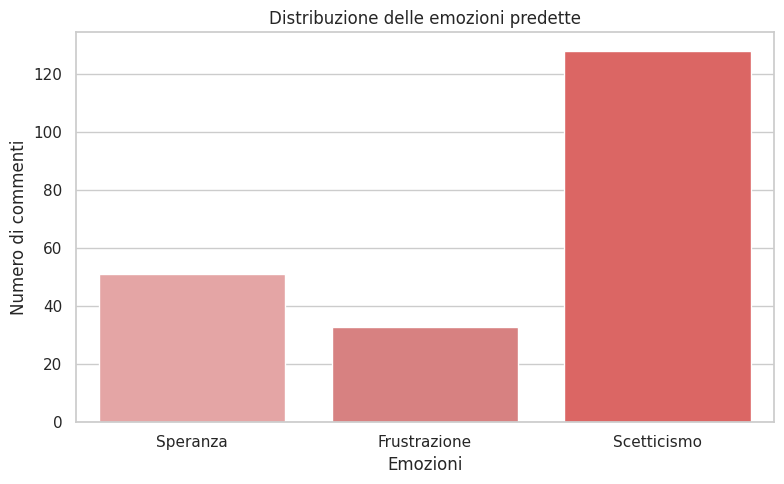

In [ ]:
#GENERIAMO IL GRAFICO:
palette_rossa = ["#ef9a9a", "#e57373", "#ef5350", "#c62828"]
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Emozioni_predette", palette=palette_rossa)

#Titolo ed etichette
plt.title("Distribuzione delle emozioni predette")
plt.xlabel("Emozioni")
plt.ylabel("Numero di commenti")
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv("Dataset_FDB_emoz.csv")

if "Emozioni_manuali" in df.columns and "Emozioni_predette" in df.columns:
    print("Report di valutazione tra etichette manuali e predette:")
    print(classification_report(df["Emozioni_manuali"], df["Emozioni_predette"]))

Report di valutazione tra etichette manuali e predette:
              precision    recall  f1-score   support

Frustrazione       0.79      0.16      0.27       161
 Scetticismo       0.13      0.71      0.22        24
    Speranza       0.25      0.48      0.33        27

    accuracy                           0.26       212
   macro avg       0.39      0.45      0.28       212
weighted avg       0.65      0.26      0.27       212



#### Report di valutazione
L'**accuracy** complessiva è del 26%: performance inaccettabile per qualsiasi applicazione pratica, anche il **Recall** è molto basso per **"Frustrazione"** (0.16), in quanto il modello perde l'84% dei casi reali.
**Precision** pessima per **"Scetticismo"** (0.13): ogni predizione ha solo il 13% di probabilità di essere corretta.
**F1-scores** in generale sempre bassi su tutte le classi (0.22-0.33), indicando un fallimento sistemico, ma **Recall** dello **"Scetticismo"** (0.71): pur con precision bassa, riesce a catturare la maggior parte dei casi reali di questa classe.

Il divario tra weighted average (precision 0.65) e macro average (precision 0.39) evidenzia come la classe dominante "Frustrazione" influenzi artificialmente le metriche ponderate. La macro average rivela la reale incapacità del modello di gestire tutte le classi equamente.

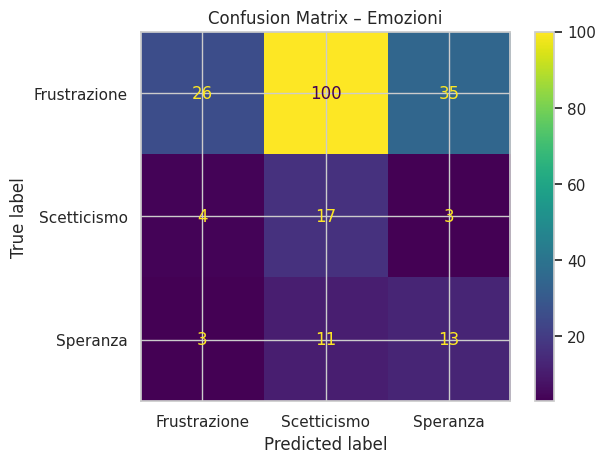

In [ ]:
#Matrice di confusione
df = pd.read_csv("Dataset_FDB_emoz.csv")

cm = confusion_matrix(df["Emozioni_manuali"], df["Emozioni_predette"])
labels = sorted(df["Emozioni_manuali"].unique())
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot()
plt.title("Confusion Matrix – Emozioni")
plt.show()

#### Matrice di confusione
La matrice di confusione presenta i risultati di un modello sviluppato, per il riconoscimento automatico delle **emozioni** in testi italiani. Il sistema è progettato per classificare contenuti testuali in **tre stati emotivi** fondamentali: Frustrazione, Scetticismo e Speranza, rispettivamente:
- **Frustrazione**: espressioni di disappunto, irritazione e insoddisfazione;
- **Scetticismo**: manifestazioni di dubbio, diffidenza e atteggiamento critico;
- **Speranza**: contenuti che trasmettono ottimismo, aspettative positive e fiducia nel futuro.

Il pattern più evidente è la frequente predizione verso **"Scetticismo"** con 100 casi classificati come **"Frustrazione"** ma predetti come **"Scetticismo"**. Questo indica che il modello ha sviluppato un **bias** verso la classe centrale, probabilmente dovuto a **caratteristiche linguistiche sovrapposte tra le categorie emotive**.  

Le classi **"Scetticismo"** e **"Speranza"** mostrano performance estremamente deboli con rispettivamente solo 17 e 13 true positives, mentre **"Frustrazione"** riesce a identificare correttamente solo 26 casi su 161 totali.   
*Quindi possiamo affermare che il modello non riesce a catturare le sfumature distintive tra questi stati emotivi.*

## CONCLUSIONI
Dopo aver **analizzato automaticamente** *il sentiment, le tematiche e le emozioni* e confrontato i *risultati predetti automaticamente* con quelli dell'**annotazione manuale** condotta nella tesi di laurea triennale, emerge chiaramente che i modelli testati (Word2Vec, Word2Vec locale, Sentence Transformer) presentano performance inferiori rispetto al **gold standard** manuale.   

Le **matrici di confusione**,relative alle tematiche e alle emozioni, rivelano **bias sistematici, collassi categoriali** e **distribuzioni asimmetriche** che compromettono l'affidabilità delle predizioni automatiche.  

Per concludere le considerazioni su questo progetto posso affermare che, per utilizzare efficacemente questi modelli è sicuramente necessario un **dataset più ampio**, che possa fornire esempi rappresentativi sufficienti per ogni categoria e garantire performance comparabili a quelle dell'annotazione manuale. Inoltre, selezionare **più frasi standard** diventa fondamentale per far cogliere meglio le sfumature fra le diverse classi emotive e migliorare la capacità distintiva del modello.